# Initialisation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import cv2
import os
import sys
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab.patches import cv2_imshow

CORNER_ARCHIVE_PATH = '/content/drive/MyDrive/data24/corner/corner'
NO_CORNER_ARCHIVE_PATH = '/content/drive/MyDrive/data24/corner/no_corner'
CSV_PATH = '/content/drive/MyDrive/data24/corner/csv'
CORNER_PATH = '/content/data/corner/corner'
NO_CORNER_PATH = '/content/data/corner/no_corner'
CSV_OUT_PATH = '/content/data/csv'

TARGET_OUTPUT_PATH_ARCHIVES = '/content/drive/MyDrive/data24/corner/targets'
TARGET_OUTPUT_PATH = '/content/data/corner/targets'
UPSAMPLED_IMAGES_PATH_ARCHIVES = '/content/drive/MyDrive/data24/corner/images_upsampled'
UPSAMPLED_IMAGES_PATH = '/content/data/corner/images_upsampled'
UPSAMPLED_TARGETS_PATH_ARCHIVES = '/content/drive/MyDrive/data24/corner/targets_upsampled'
UPSAMPLED_TARGETS_PATH = '/content/data/corner/targets_upsampled'

MODEL_OUTPUT_PATH = '/content/drive/MyDrive/corner.tflite'

TEST_IMAGES_PATH = '/content/drive/MyDrive/data24/corner/test'

os.makedirs(CORNER_PATH, exist_ok=True)
os.makedirs(NO_CORNER_PATH, exist_ok=True)
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)
os.makedirs(UPSAMPLED_IMAGES_PATH, exist_ok=True)
os.makedirs(UPSAMPLED_TARGETS_PATH, exist_ok=True)
os.makedirs(CSV_OUT_PATH, exist_ok=True)

def remove_quotation_marks(x):
  return x.replace('"', '').strip()

input_height = 120
input_width = 160
Xs = 32
Ys = 12
Cs = 2
chunk_height = input_height / Ys
chunk_width = input_width / Xs

# Unpack data to local runtime


In [3]:
import shutil
import zipfile

archive_dirs = [CORNER_ARCHIVE_PATH, NO_CORNER_ARCHIVE_PATH]
out_dirs = [CORNER_PATH, NO_CORNER_PATH]

for i, dir in enumerate(archive_dirs):
  for archive in os.listdir(dir):
    print(f"Unpacking {archive}...")
    with zipfile.ZipFile(dir + "/" + archive) as zip_file:
      for member in zip_file.namelist():
          filename = os.path.basename(member)
          # skip directories
          if not filename:
              continue

          # copy file (taken from zipfile's extract)
          source = zip_file.open(member)
          try:
            target = open(os.path.join(out_dirs[i], filename), "wb")
            with source, target:
              shutil.copyfileobj(source, target)
          except:
            pass

for csv in os.listdir(CSV_PATH):
  print(f"Copying {csv}...")
  with open(CSV_PATH + "/" + csv, "r") as f:
    f2 = open(CSV_OUT_PATH + "/" + csv, "w")
    f2.write(f.read())
    f2.close()

"""for archive in os.listdir(VICTIMS_PATH_ARCHIVES):
  print(f"Unpacking {archive}...")
  shutil.unpack_archive(VICTIMS_PATH_ARCHIVES + "/" + archive, extract_dir=VICTIMS_PATH)

for archive in os.listdir(NO_VICTIMS_PATH_ARCHIVES):
  print(f"Unpacking {archive}...")
  shutil.unpack_archive(NO_VICTIMS_PATH_ARCHIVES + "/" + archive, extract_dir=NO_VICTIMS_PATH)"""

Unpacking Kopie von Kopie von daten_bordeaux_2.zip...
Unpacking Kopie von Kopie von daten_bordeaux.zip...
Unpacking corner_2024_04_09.zip...
Unpacking corner_2024_06_14_resized.zip...
Unpacking Kopie von no_corner_01.zip...
Unpacking Kopie von no_corner_kassel.zip...
Unpacking Kopie von no_corner_wm.zip...
Unpacking Kopie von no_corner_02.zip...
Copying corner_21_01_2024-export.csv...
Copying Kopie von Kopie von daten_bordeaux_2.csv...
Copying Kopie von Kopie von daten_bordeaux.csv...
Copying corner_2024_04_09-resized.csv...
Copying corner_2024_06_14-resized.csv...


'for archive in os.listdir(VICTIMS_PATH_ARCHIVES):\n  print(f"Unpacking {archive}...")\n  shutil.unpack_archive(VICTIMS_PATH_ARCHIVES + "/" + archive, extract_dir=VICTIMS_PATH)\n\nfor archive in os.listdir(NO_VICTIMS_PATH_ARCHIVES):\n  print(f"Unpacking {archive}...")\n  shutil.unpack_archive(NO_VICTIMS_PATH_ARCHIVES + "/" + archive, extract_dir=NO_VICTIMS_PATH)'

# Generate targets

In [4]:
targets = {}
images_without_corners = set() # Images that are never labelled green_corner or red_corner

empty_target = np.zeros((Ys, Xs, 3), dtype=np.float32) # Three channels because these are saved as PNGs, actually 2 (red and green)
c_nv = 0

for csv_path in os.listdir(CSV_OUT_PATH):
  if not (csv_path[-3:] == "csv"):
    continue
  with open(CSV_OUT_PATH + "/" + csv_path, "r") as f:
    for row in f.readlines()[1:]:
      cols = row.split(',')

      filename = remove_quotation_marks(cols[0])
      if not os.path.isfile(CORNER_PATH + "/" + filename):
        continue

      label = remove_quotation_marks(cols[5])

      if(label == "no_corner"):
        cv2.imwrite(TARGET_OUTPUT_PATH + "/" + filename, empty_target)
        c_nv += 1
        continue

      if not (label == "red_corner" or label == "green_corner"):
        if not filename in targets:
          images_without_corners.add(filename)
        continue

      xmin = float(cols[1])
      ymin = float(cols[2])
      xmax = float(cols[3])
      ymax = float(cols[4])
      red = label == "red_corner"

      if not filename in targets:
        if filename in images_without_corners:
          images_without_corners.remove(filename)

        targets[filename] = np.zeros((Ys, Xs, Cs), dtype=np.float32)

      for y in range(Ys):
        for x in range(Xs):
          chunk_center_x = (x + 0.5) * chunk_width
          chunk_center_y = (y + 0.5) * chunk_height

          if xmin < chunk_center_x < xmax and ymin < chunk_center_y < ymax:
            # This chunk intersects the bounding box of the corner
            if red:
              targets[filename][y, x, 0] = 1.0
            else:
              targets[filename][y, x, 1] = 1.0

c_v = 0

t = None

# Output targets with corners
for filename in targets:
  t = np.pad(targets[filename], ((0, 0), (0, 0), (0, 1))) * 255.0   # Pad because we can only save three-channel images
  f = TARGET_OUTPUT_PATH + "/" + filename
  f2 = CORNER_PATH + "/" + filename
  cv2.imwrite(TARGET_OUTPUT_PATH + "/" + filename, t)
  c_v += 1

# Targets with no corners
for filename in os.listdir(NO_CORNER_PATH):
  cv2.imwrite(TARGET_OUTPUT_PATH + "/" + filename, empty_target)
  c_nv += 1

# Other targets with no corners
for filename in images_without_corners:
  cv2.imwrite(TARGET_OUTPUT_PATH + "/" + filename, empty_target)
  c_nv += 1

"""# Output targets with no victims
for filename in os.listdir(NO_VICTIMS_PATH):
  cv2.imwrite(TARGET_OUTPUT_PATH + "/" + filename, empty_target)
  c_nv += 1"""

print(f"Wrote {c_v + c_nv} targets [{c_v} (corners), {c_nv} (no corners)]")

Wrote 21082 targets [6514 (corners), 14568 (no corners)]


# Upsample data

In [5]:
l = os.listdir(TARGET_OUTPUT_PATH)
c = 0

for filename in l:
  image_path = CORNER_PATH + "/" + filename

  if not os.path.isfile(image_path):
    image_path = NO_CORNER_PATH + "/" + filename

  if not os.path.isfile(image_path):
    print(f"Target {filename} has no image")

  try:
    target_image = cv2.imread(TARGET_OUTPUT_PATH + "/" + filename, cv2.IMREAD_COLOR)
    cv2.imwrite(UPSAMPLED_TARGETS_PATH + "/" + filename, target_image)

    filename_f = filename[0:-4] + "_f.png"
    # Flip target
    target_flipped = np.flip(target_image, axis=1)
    cv2.imwrite(UPSAMPLED_TARGETS_PATH + "/" + filename_f, target_flipped)

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    cv2.imwrite(UPSAMPLED_IMAGES_PATH + "/" + filename, image)

    # Flip image
    image_flipped = np.flip(image, axis=1)
    cv2.imwrite(UPSAMPLED_IMAGES_PATH + "/" + filename_f, image_flipped)
  except:
    print(f"{filename} had an error.")
    continue

  c += 1
print(f"Upsampled {c} / {len(l)} images.\r")

1677174726207.png had an error.
1677174726001.png had an error.
1677174726502.png had an error.
1677174728433.png had an error.
1677174725833.png had an error.
1677174727038.png had an error.
1677174721705.png had an error.
1677174726567.png had an error.
1677174727370.png had an error.
1677174726902.png had an error.
1677174727203.png had an error.
1677174727537.png had an error.
1677174728135.png had an error.
1677174728798.png had an error.
1675961631671.png had an error.
1677174728633.png had an error.
1677174729000.png had an error.
1677174723870.png had an error.
1677174727668.png had an error.
1675960750881.png had an error.
1677174727833.png had an error.
1677174727968.png had an error.
1677174728299.png had an error.
1677174724103.png had an error.
1677174726302.png had an error.
1677174726837.png had an error.
Upsampled 20395 / 20421 images.


# Train and export

In [6]:
# Load images
images = []
targets = []

print(f"Loading images and targets from {UPSAMPLED_IMAGES_PATH}")

for filename in os.listdir(UPSAMPLED_IMAGES_PATH):
  img = cv2.imread(UPSAMPLED_IMAGES_PATH + "/" + filename, cv2.IMREAD_COLOR)

  if(img.size != input_height * input_width * 3):
    print(f"Target {filename} is wrong size")
    continue
  images.append(img)

  target = cv2.imread(UPSAMPLED_TARGETS_PATH + "/" + filename, cv2.IMREAD_COLOR)[:,:,0:2].astype(np.float32) / 255.0

  if(target.size != Ys * Xs * Cs):
    print(f"Target {filename} is wrong size")
    continue
  targets.append(target)

images = np.array(images)
targets = np.array(targets)

batch_size = 16

# WORKING MODEL
"""
model = Sequential([
  layers.Rescaling(1./255, input_shape=(input_height, input_width, 1)),
  layers.Conv2D(8, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(2),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(4),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(2),
  layers.Dropout(0.3),
  layers.Flatten(),
  #layers.Dense(1024, activation='linear'),
  layers.Dense(Ys * Xs * Cs, activation='linear'),
  layers.Reshape((Ys, Xs, Cs))
])
"""

# NEW MODEL
model = Sequential([
    layers.Rescaling(1./255, input_shape=(input_height, input_width, 3)),
    layers.Conv2D(8, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(8),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(Ys * Xs * Cs, activation='linear'),
    layers.Reshape((Ys, Xs, Cs))
])

model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=['accuracy'])

model.summary()

model.fit(images, targets, batch_size=batch_size, epochs=40, verbose=1)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(MODEL_OUTPUT_PATH, 'wb') as f:
  f.write(tflite_model)

Loading images and targets from /content/data/corner/images_upsampled
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 160, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 20, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 20, 16)        1168      
                                                                 
 dropout (Dropout)           (None, 15, 20, 16)        0         
                                                                 
 flatten (Flatten)           (None, 4800)           

# Test

0.03442072868347168


52.0


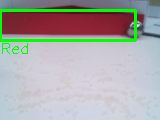

---------------------
0.009500741958618164


90.0


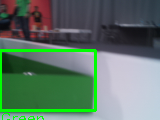

---------------------
0.011274337768554688


77.0


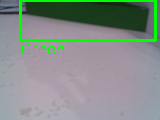

---------------------
0.011185407638549805


67.0


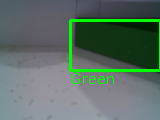

---------------------
0.008002042770385742


88.0


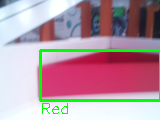

---------------------
0.008027315139770508


155.0


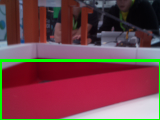

---------------------


In [9]:
import tensorflow as tf
import time

test_images = []
original_images = []
for img in os.listdir(TEST_IMAGES_PATH):
  image = cv2.imread(TEST_IMAGES_PATH + "/" + img, cv2.IMREAD_COLOR).astype(np.float32)
  original_images.append(image)
  #image = np.expand_dims(image, axis=0)
  #image = np.expand_dims(image, axis=3)
  image = tf.convert_to_tensor(image, dtype=tf.float32)
  image = tf.expand_dims(image, 0)
  test_images.append(image)

interpreter = tf.lite.Interpreter(model_path=MODEL_OUTPUT_PATH)
interpreter.allocate_tensors()

output = interpreter.get_output_details()[0]
input = interpreter.get_input_details()[0]

for i, image in enumerate(test_images):
  start_time = time.time()

  interpreter.set_tensor(input['index'], image)
  interpreter.invoke()
  out = interpreter.get_tensor(output['index'])

  end_time = time.time()

  print(end_time - start_time)

  image = original_images[i]
  out = np.clip(out[0,:,:] * 255.0, 0.0, 255.0).astype(np.uint8)

  out_red = out[:,:,0:1]
  out_green = out[:,:,1:2]

  cv2_imshow(out_red)
  cv2_imshow(out_green)

  # Find largest contour
  _, map_red = cv2.threshold(out_red, 100, 255, cv2.THRESH_BINARY)
  _, map_green = cv2.threshold(out_green, 100, 255, cv2.THRESH_BINARY)

  contours_red, _ = cv2.findContours(map_red, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours_green, _ = cv2.findContours(map_green, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  horizontal_factor = input_width / Xs
  vertical_factor = input_height / Ys

  largest_contour = None
  largest_contour_red = False

  contours = contours_green + contours_red

  if len(contours) > 0:
    largest_contour = max(contours, key=cv2.contourArea)

    print(cv2.contourArea(largest_contour))
    x, y, w, h = cv2.boundingRect(largest_contour)
    x = int(x * horizontal_factor)
    y = int(y * vertical_factor)
    w = int(w * horizontal_factor)
    h = int(h * vertical_factor)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    red = largest_contour in contours_red
    text = "Red"
    if not red:
      text = "Green"

    cv2.putText(image, text, (x, y + h + 13), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

  cv2_imshow(image)
  print("---------------------")